# 1. Import packages and setup

In [2]:
import os
import numpy as np
import torch
from PIL import Image
from torchvision import transforms

In [3]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None, low_res_factor=4):
        self.root_dir = root_dir
        self.paths = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
        self.transform = transform
        self.factor = low_res_factor

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        
        hr_img = Image.open(path).convert('RGB')

        lr_size = (hr_img.size[0] // self.factor, hr_img.size[1] // self.factor)
        lr_img = hr_img.resize(lr_size, Image.BICUBIC)

        if self.transform:
            hr_img = self.transform(hr_img)
            lr_img = self.transform(lr_img)

        return lr_img, hr_img

In [4]:
print(torch.__version__)

2.4.1+cu121


In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# 2. Datasets

In [6]:
data_dir = '/kaggle/input/celebahq-resized-256x256/celeba_hq_256'

transform = transforms.Compose([
    transforms.ToTensor(),  # Chuyển ảnh thành Torch tensor
    # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Chuẩn hóa giá trị pixel về [-1, 1]
])

dataset = CustomDataset(data_dir, transform, 4)

In [7]:
lr_example, hr_example = dataset[1]
lr_example.shape, hr_example.shape

(torch.Size([3, 64, 64]), torch.Size([3, 256, 256]))

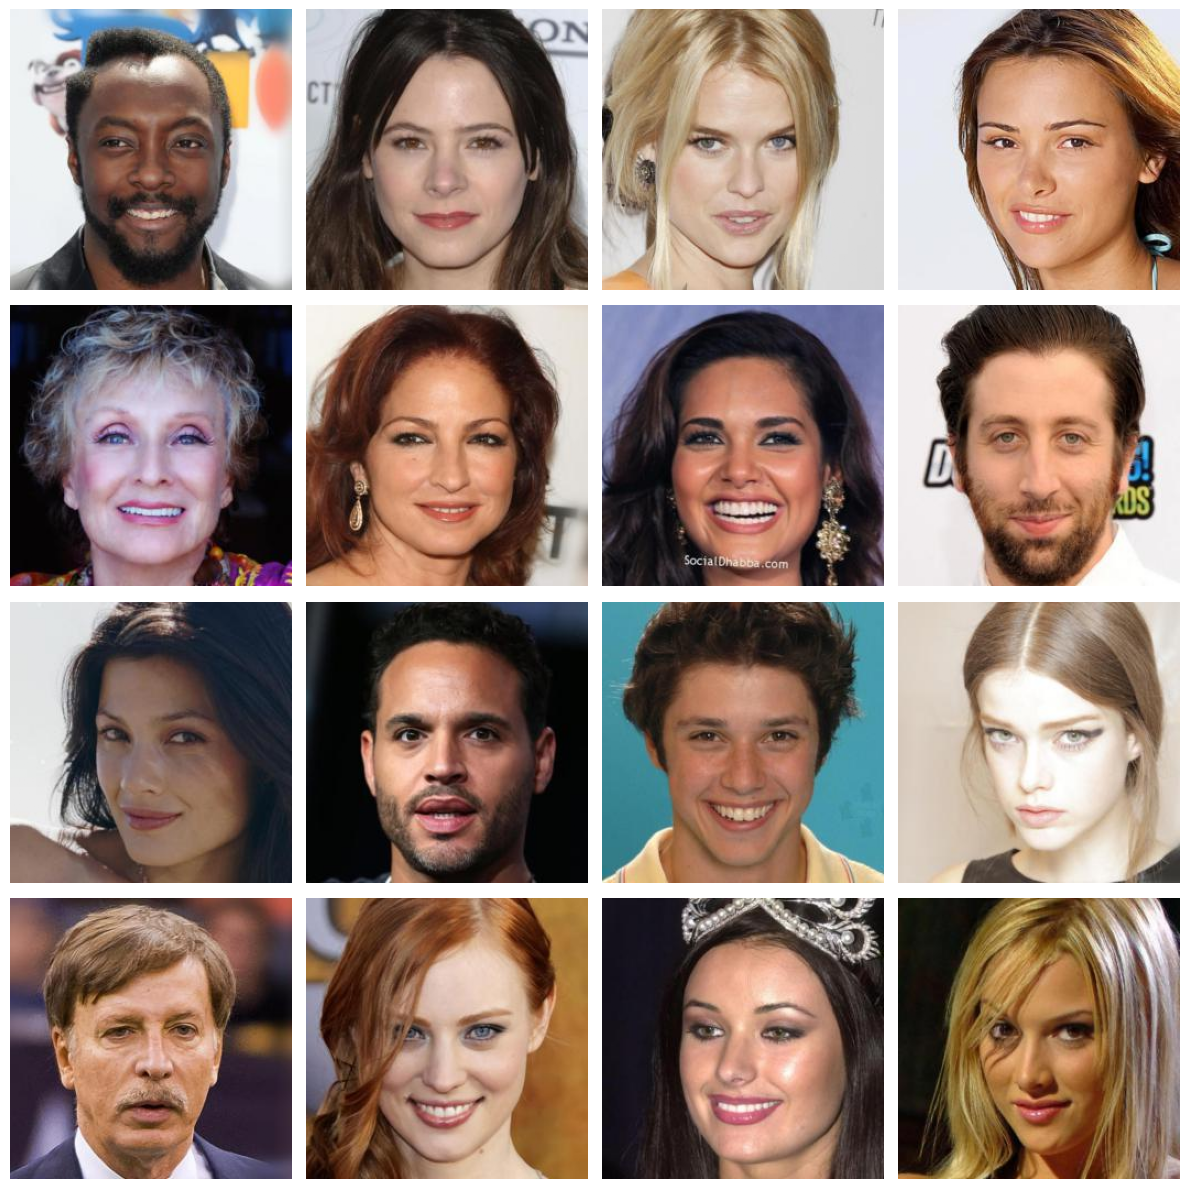

In [35]:
import matplotlib.pyplot as plt

# Số ảnh muốn hiển thị
num_images = 16

# Kích thước lưới để hiển thị ảnh
grid_size = int(num_images**0.5)

# Tạo lưới các ảnh
fig, axes = plt.subplots(grid_size, grid_size, figsize=(12, 12))
axes = axes.flatten()

for i in range(num_images):
    _, hr_example = dataset[i]  # Chỉ lấy ảnh HR
    # Chuyển tensor sang numpy để hiển thị
    image = hr_example.permute(1, 2, 0).numpy()  # Chuyển kênh (C, H, W) sang (H, W, C)
    axes[i].imshow(image)
    axes[i].axis('off')

plt.tight_layout()
plt.show()


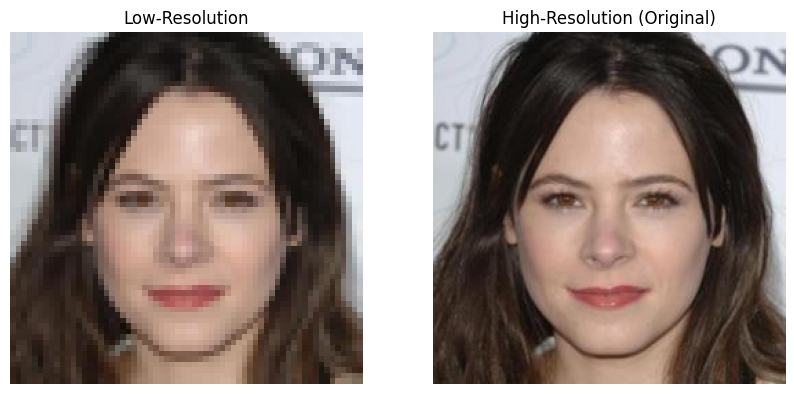

In [7]:
import matplotlib.pyplot as plt

lr_example_np = np.transpose(lr_example.numpy(), (1, 2, 0))
hr_example_np = np.transpose(hr_example.numpy(), (1, 2, 0))

plt.figure(figsize=(10, 5))

# Ảnh low-res
plt.subplot(1, 2, 1)
plt.imshow(lr_example_np)
plt.title("Low-Resolution")
plt.axis("off")

# Ảnh high-res
plt.subplot(1, 2, 2)
plt.imshow(hr_example_np)
plt.title("High-Resolution (Original)")
plt.axis("off")

plt.show()

In [ ]:
from torch.utils.data import DataLoader, random_split

train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

total_size = len(dataset)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size

# Split into Train, Val, Test set
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Tạo DataLoader cho từng tập
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Kiểm tra kích thước từng tập
print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")

# 3. Initial evaluation

In [8]:
import torch
import torchvision
import torchvision.transforms.functional as TF

def interpolation_upsample(lr_img, device, target_size=(256, 256), mode=torchvision.transforms.InterpolationMode.BICUBIC):
    lr_img = lr_img.to(device)
    sr_img = TF.resize(lr_img, size=target_size, interpolation=mode)
    # sr_img = torch.clamp(sr_img, 0, 1)
    sr_img.cpu()   
    return sr_img

In [ ]:
original_images = []
lr_images = []
bicubic_sr_images = []
bilinear_sr_images = []
nearest_sr_images = []

# Duyệt qua các ảnh trong test_loader và tăng độ phân giải
with torch.no_grad():
    for lr_img_batch, hr_img_batch in test_loader:
        lr_images.append(lr_img_batch)
        original_images.append(hr_img_batch)

        bicubic_sr_img = interpolation_upsample(lr_img_batch, device, mode=torchvision.transforms.InterpolationMode.BICUBIC)
        bilinear_sr_img = interpolation_upsample(lr_img_batch, device, mode=torchvision.transforms.InterpolationMode.BILINEAR)
        nearest_sr_img = interpolation_upsample(lr_img_batch, device, mode=torchvision.transforms.InterpolationMode.NEAREST)
        
        bicubic_sr_images.append(bicubic_sr_img)
        bilinear_sr_images.append(bilinear_sr_img)
        nearest_sr_images.append(nearest_sr_img)

In [ ]:
len(lr_images), len(original_images), len(bicubic_sr_images), len(bilinear_sr_images), len(nearest_sr_images)

In [9]:
from torchmetrics.image import StructuralSimilarityIndexMeasure as SSIM
import math

def psnr(img1, img2):
    img1 = img1.cpu().detach().numpy()
    img2 = img2.cpu().detach().numpy()
    img_diff = img1 - img2
    rmse = math.sqrt(np.mean((img_diff)**2))
    if rmse == 0:
        return 100
    else:
        psnr = 20 * math.log10(1./rmse)
        return psnr

# def psnr(img1, img2):
#     mse = torch.mean((img1 - img2) ** 2)
#     psnr_value = 10 * torch.log10(1.0 / (mse))
#     return psnr_value

def ssim(img1, img2, device):
    img2 = img2.to(device)
    ssim = SSIM(data_range=1.0).to(device)
    return ssim(img1, img2)

def evaluate(sr_images, original_images, device):
    psnr_values = []
    ssim_values = []

    for sr_img, original_img in zip(sr_images, original_images):
        # Tính PSNR
        psnr_val = psnr(sr_img, original_img)
        psnr_values.append(psnr_val)
        
        # Tính SSIM
        ssim_val = ssim(sr_img, original_img, device)
        ssim_values.append(ssim_val.item())

    avg_psnr = torch.mean(torch.tensor(np.array(psnr_values), dtype=torch.float))
    avg_ssim = torch.mean(torch.tensor(ssim_values))

    return avg_psnr, avg_ssim

In [ ]:
bicubic_psnr, bicubic_ssim = evaluate(bicubic_sr_images, original_images, device)
bilinear_psnr, bilinear_ssim = evaluate(bilinear_sr_images, original_images, device)
nearest_psnr, nearest_ssim = evaluate(nearest_sr_images, original_images, device)

In [ ]:
print(bicubic_psnr.item(), bicubic_ssim.item())
print(bilinear_psnr.item(), bilinear_ssim.item())
print(nearest_psnr.item(), nearest_ssim.item())

# 4. SRCNN

In [7]:
from torch import nn
from tqdm import tqdm
import torch.optim as optim

In [ ]:
class SRCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 64, 9, padding=2, padding_mode='replicate')
        self.conv2 = nn.Conv2d(64, 32, 1, padding=2, padding_mode='replicate')
        self.conv3 = nn.Conv2d(32, 3, 5, padding=2, padding_mode='replicate')

    def forward(self, x):
        x = nn.functional.interpolate(x, scale_factor=4, mode='bicubic', align_corners=False)
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = self.conv3(x)

        return x

In [ ]:
srcnn_model = SRCNN().to(device)
batch_sample_lr, batch_sample_hr = next(iter(train_loader))
srcnn_model(batch_sample_lr.to(device)).shape

In [ ]:
srcnn_model

In [ ]:
optimizer_srcnn = optim.Adam(srcnn_model.parameters(), lr=1e-4, weight_decay=1e-5)
loss_fn = nn.MSELoss()

In [ ]:
epochs = 30

train_loss_list = []
train_psnr_list = []
train_ssim_list = []

val_loss_list = []
val_psnr_list = []
val_ssim_list = []


for epoch in range(epochs):
    srcnn_model.train()
    print(f'Epoch #{epoch + 1}')

    # Reset các thông số cho epoch
    epoch_loss = 0
    epoch_psnr = 0
    epoch_ssim = 0

    for lr, hr in tqdm(train_loader, desc=f'Training Epoch {epoch + 1}'):
        torch.cuda.empty_cache()
        
        lr = lr.to(device)
        hr = hr.to(device)

        # Forward pass
        sr = srcnn_model(lr).to(device)

        # Tính loss
        train_loss = loss_fn(sr, hr)

        # Backward pass và tối ưu hóa
        optimizer_srcnn.zero_grad()
        train_loss.backward()
        optimizer_srcnn.step()

        # Tính PSNR và SSIM
        train_psnr = psnr(sr, hr)
        train_ssim = ssim(sr, hr)

        # Cộng dồn loss, PSNR và SSIM
        epoch_loss += train_loss.item()
        epoch_psnr += train_psnr
        epoch_ssim += train_ssim.item()
        
    # Tính giá trị trung bình cho các thông số training
    avg_train_loss = epoch_loss / len(train_loader)
    avg_train_psnr = epoch_psnr / len(train_loader)
    avg_train_ssim = epoch_ssim / len(train_loader)

    # Lưu các thông số vào danh sách
    train_loss_list.append(avg_train_loss)
    train_psnr_list.append(avg_train_psnr)
    train_ssim_list.append(avg_train_ssim)

    # In các thông số training
    print(f"Training - Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}, SSIM: {avg_train_ssim:.4f}")

    # Đánh giá trên tập validation
    srcnn_model.eval()
    with torch.no_grad():
        val_epoch_loss = 0
        val_epoch_psnr = 0
        val_epoch_ssim = 0

        for lr, hr in tqdm(val_loader, desc=f'Validation Epoch {epoch + 1}'):
            torch.cuda.empty_cache()
            lr = lr.to(device)
            hr = hr.to(device)

            sr = srcnn_model(lr).to(device)

            # Tính loss, PSNR, và SSIM trên tập validation
            val_loss = loss_fn(sr, hr)
            val_psnr = psnr(sr, hr)
            val_ssim = ssim(sr, hr)

            # Cộng dồn các giá trị
            val_epoch_loss += val_loss.item()
            val_epoch_psnr += val_psnr
            val_epoch_ssim += val_ssim.item()

        # Tính giá trị trung bình cho các thông số validation
        avg_val_loss = val_epoch_loss / len(val_loader)
        avg_val_psnr = val_epoch_psnr / len(val_loader)
        avg_val_ssim = val_epoch_ssim / len(val_loader)

        # Lưu các thông số vào danh sách
        val_loss_list.append(avg_val_loss)
        val_psnr_list.append(avg_val_psnr)
        val_ssim_list.append(avg_val_ssim)

        # In các thông số validation
        print(f"Validation - Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}, SSIM: {avg_val_ssim:.4f}")
        
torch.save(sr.state_dict(), './checkpoint/srcnn.pth')

In [ ]:
srcnn_model.eval()
with torch.no_grad():
    test_psnr = 0
    test_ssim = 0

    for lr, hr in tqdm(test_loader, desc=f'Validation Epoch {epoch + 1}'):
        torch.cuda.empty_cache()
        lr = lr.to(device)
        hr = hr.to(device)

        sr = srcnn_model(lr).to(device)

        test_batch_psnr = psnr(sr, hr)
        test_batch_ssim = ssim(sr, hr)

        test_psnr += test_batch_psnr
        test_ssim += test_batch_ssim.item()

    avg_psnr = test_psnr / len(test_loader)
    avg_ssim = test_ssim / len(test_loader)

avg_psnr, avg_ssim

# 5. SRGAN

In [10]:
# import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.prelu = nn.PReLU()
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(in_channels)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.prelu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        return out + residual

class Generator(nn.Module):
    def __init__(self, num_residual_blocks=16):
        super(Generator, self).__init__()
        self.initial_conv = nn.Conv2d(3, 64, kernel_size=9, stride=1, padding=4)
        self.initial_prelu = nn.PReLU()

        self.residual_blocks = nn.Sequential(
            *[ResidualBlock(64) for _ in range(num_residual_blocks)]
        )

        self.mid_conv = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.mid_bn = nn.BatchNorm2d(64)

        self.upsample_blocks = nn.Sequential(
            nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1),
            nn.PixelShuffle(2),
            nn.PReLU(),

            nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1),
            nn.PixelShuffle(2),
            nn.PReLU()
        )

        self.final_conv = nn.Conv2d(64, 3, kernel_size=9, stride=1, padding=4)

    def forward(self, x):
        initial = self.initial_prelu(self.initial_conv(x))
        residual = self.residual_blocks(initial)
        mid = self.mid_bn(self.mid_conv(residual))
        out = initial + mid
        out = self.upsample_blocks(out)
        out = self.final_conv(out)
        return out

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_channels, out_channels, stride):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(0.2, inplace=True)
            )

        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            discriminator_block(64, 64, stride=2),
            discriminator_block(64, 128, stride=1),
            discriminator_block(128, 128, stride=2),
            discriminator_block(128, 256, stride=1),
            discriminator_block(256, 256, stride=2),
            discriminator_block(256, 512, stride=1),
            discriminator_block(512, 512, stride=2),

            nn.Flatten(),
            nn.Linear(512 * 16 * 16, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 1)
        )

    def forward(self, x):
        return F.sigmoid(self.model(x))

class SRGAN(nn.Module):
    def __init__(self, img_size=64, num_residual_blocks=6):
        super(SRGAN, self).__init__()
        self.generator = Generator(num_residual_blocks=num_residual_blocks)
        self.discriminator = Discriminator()

    def forward(self, lr_image):
        sr_image = self.generator(lr_image)
        disc_out = self.discriminator(sr_image)
        return sr_image, disc_out

In [ ]:
srgan_model = SRGAN().to(device)
batch_sample_lr, batch_sample_hr = next(iter(train_loader))
srgan_model(batch_sample_lr.to(device))[0].shape

In [ ]:
srgan_model

In [ ]:
# Training and Testing Blocks for SRGAN
def train_srgan(generator, discriminator, train_loader, criterion, gen_optimizer, disc_optimizer, device):
    generator.train()
    discriminator.train()

    total_gen_loss = 0
    total_disc_loss = 0

    for lr_images, hr_images in tqdm(train_loader):
        lr_images = lr_images.to(device)
        hr_images = hr_images.to(device)

        # Train Discriminator
        sr_images = generator(lr_images)

        real_labels = torch.ones(hr_images.size(0), 1).to(device)
        fake_labels = torch.zeros(hr_images.size(0), 1).to(device)

        disc_optimizer.zero_grad()

        real_loss = criterion(discriminator(hr_images), real_labels)
        fake_loss = criterion(discriminator(sr_images.detach()), fake_labels)
        disc_loss = real_loss + fake_loss
        disc_loss.backward()
        disc_optimizer.step()

        # Train Generator
        gen_optimizer.zero_grad()

        adversarial_loss = criterion(discriminator(sr_images), real_labels)
        content_loss = nn.functional.mse_loss(sr_images, hr_images)
        gen_loss = content_loss + 1e-3 * adversarial_loss
        gen_loss.backward()
        gen_optimizer.step()

        total_gen_loss += gen_loss.item()
        total_disc_loss += disc_loss.item()

    avg_gen_loss = total_gen_loss / len(train_loader)
    avg_disc_loss = total_disc_loss / len(train_loader)

    torch.save(generator.state_dict(), "generator.pth")
    torch.save(discriminator.state_dict(), "discriminator.pth")

    return avg_gen_loss, avg_disc_loss

In [ ]:
def test_srgan(generator, test_loader, device):
    generator.eval()

    avg_psnr = 0
    avg_ssim = 0
    total_batches = 0

    with torch.no_grad():
        for lr_images, hr_images in tqdm(test_loader):
            lr_images = lr_images.to(device)
            hr_images = hr_images.to(device)

            sr_images = generator(lr_images)

            batch_psnr = psnr(sr_images, hr_images)
            batch_ssim = ssim(sr_images, hr_images, device)
            avg_psnr += batch_psnr
            avg_ssim += batch_ssim.item()
            total_batches += 1

    avg_psnr /= total_batches
    avg_ssim /= total_batches

    return avg_psnr, avg_ssim

In [ ]:
from torch import optim
from tqdm import tqdm

# Initialize generator and discriminator
srgan = SRGAN()
generator = srgan.generator.to(device)
discriminator = srgan.discriminator.to(device)

# Define loss function and optimizers
criterion = nn.BCEWithLogitsLoss()
gen_optimizer = optim.Adam(generator.parameters(), lr=1e-4, betas=(0.9, 0.999))
disc_optimizer = optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.9, 0.999))

In [15]:
epochs = 30

# Training loop
for epoch in range(epochs):
    train_gen_loss, train_disc_loss = train_srgan(generator, discriminator, train_loader, criterion, gen_optimizer, disc_optimizer, device)
    print(f"Epoch {epoch}: Generator Loss: {train_gen_loss:.4f}, Discriminator Loss: {train_disc_loss:.4f}")

    # Validation
    # if epoch % 10 == 0:
    val_psnr, val_ssim = test_srgan(generator, val_loader, device)
    print(f"Validation PSNR: {val_psnr:.4f}, SSIM: {val_ssim:.4f}")

In [11]:
srgan = SRGAN()
generator = srgan.generator.to(device)
discriminator = srgan.discriminator.to(device)
generator.load_state_dict(torch.load("/kaggle/input/srgan/pytorch/30epoch/2/generator__.pth", weights_only=False))
discriminator.load_state_dict(torch.load("/kaggle/input/srgan/pytorch/30epoch/2/discriminator_.pth", weights_only=False))

<All keys matched successfully>

In [ ]:
# Test
test_psnr, test_ssim = test_srgan(generator, test_loader, device)
print(f"Test PSNR: {test_psnr:.4f}, SSIM: {test_ssim:.4f}")

In [ ]:
# Test
test_psnr, test_ssim = test_srgan(generator, test_loader, device)
print(f"Test PSNR: {test_psnr:.4f}, SSIM: {test_ssim:.4f}")

# 6. Compare

In [12]:
bicubic_sr_img = interpolation_upsample(lr_example, device, mode=torchvision.transforms.InterpolationMode.BICUBIC)
bilinear_sr_img = interpolation_upsample(lr_example, device, mode=torchvision.transforms.InterpolationMode.BILINEAR)
nearest_sr_img = interpolation_upsample(lr_example, device, mode=torchvision.transforms.InterpolationMode.NEAREST)

In [13]:
bicubic_sr_img.shape, bilinear_sr_img.shape, nearest_sr_img.shape

(torch.Size([3, 256, 256]),
 torch.Size([3, 256, 256]),
 torch.Size([3, 256, 256]))

In [16]:
srgan_output = generator(lr_example.unsqueeze(0).to(device))
srgan_output.shape

(torch.Size([1, 3, 256, 256]), 0.004346609115600586)

In [15]:
srcnn_output = model(lr_example.unsqueeze(0).to(device))
srcnn_output.shape

torch.Size([1, 3, 256, 256])

In [16]:
srcnn_output = srcnn_output.squeeze(0)
srgan_output = srgan_output.squeeze(0)
srcnn_output.shape, srgan_output.shape

(torch.Size([3, 256, 256]), torch.Size([3, 256, 256]))

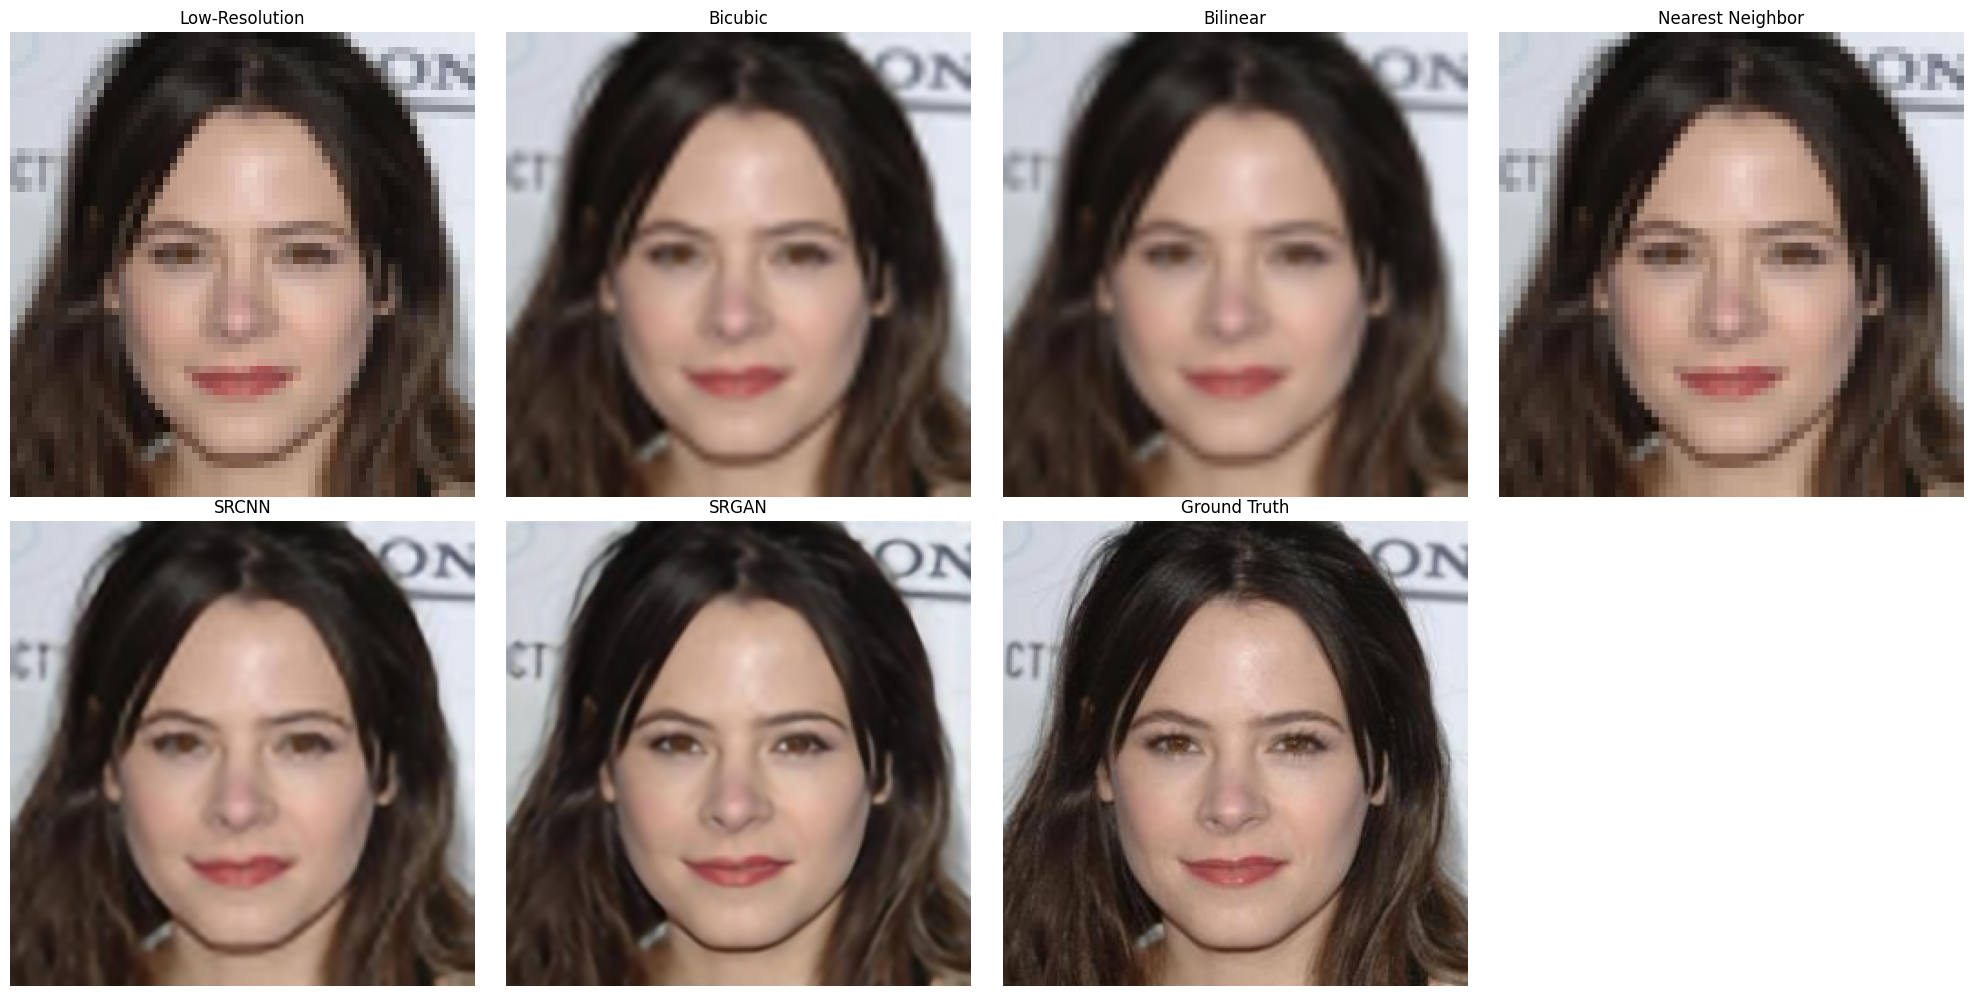

In [18]:
import matplotlib.pyplot as plt
import numpy as np

lr_example_np = np.transpose(lr_example.numpy(), (1, 2, 0))
hr_example_np = np.transpose(hr_example.numpy(), (1, 2, 0))
bicubic_sr_img_np = np.transpose(bicubic_sr_img.cpu().detach().numpy(), (1, 2, 0))
bilinear_sr_img_np = np.transpose(bilinear_sr_img.cpu().detach().numpy(), (1, 2, 0))
nearest_sr_img_np = np.transpose(nearest_sr_img.cpu().detach().numpy(), (1, 2, 0))
srcnn_np = np.transpose(srcnn_output.cpu().detach().numpy(), (1, 2, 0))
srgan_np = np.transpose(srgan_output.cpu().detach().numpy(), (1, 2, 0))

# Đặt kích thước cho toàn bộ figure (to hơn nếu cần)
plt.figure(figsize=(20, 10))

# Ảnh low-res
plt.subplot(2, 4, 1)
plt.imshow(lr_example_np)
plt.title("Low-Resolution")
plt.axis("off")

# Ảnh bicubic
plt.subplot(2, 4, 2)
plt.imshow(bicubic_sr_img_np)
plt.title("Bicubic")
plt.axis("off")

# Ảnh bilinear
plt.subplot(2, 4, 3)
plt.imshow(bilinear_sr_img_np)
plt.title("Bilinear")
plt.axis("off")

# Ảnh nn
plt.subplot(2, 4, 4)
plt.imshow(nearest_sr_img_np)
plt.title("Nearest Neighbor")
plt.axis("off")

# Ảnh SRCNN
plt.subplot(2, 4, 5)
plt.imshow(srcnn_np)
plt.title("SRCNN")
plt.axis("off")

# Ảnh SRGAN
plt.subplot(2, 4, 6)
plt.imshow(srgan_np)
plt.title("SRGAN")
plt.axis("off")

# Ảnh Ground Truth
plt.subplot(2, 4, 7)
plt.imshow(hr_example_np)
plt.title("Ground Truth")
plt.axis("off")

# Tinh chỉnh bố cục
plt.tight_layout()
plt.show()


In [23]:
import time
import torch  # Giả sử bạn đang sử dụng PyTorch

# Số lần thực hiện để tính trung bình
num_runs = 100

# Biến lưu tổng thời gian
total_time = 0

# Vòng lặp tính thời gian nhiều lần
for _ in range(num_runs):
    start_time = time.time()
    srgan_output = generator(lr_example.unsqueeze(0).to(device))
    elapsed_time = time.time() - start_time
    total_time += elapsed_time

    # In thời gian thực thi từng lần (nếu cần)
    # print(f"Thời gian thực thi lần này: {elapsed_time:.6f} giây")

# Tính thời gian trung bình
average_time = total_time / num_runs
print(f"Thời gian thực thi trung bình SRGAN: {average_time:.6f} giây")


Thời gian thực thi trung bình SRGAN: 0.009540 giây


In [24]:
import time
import torch  # Giả sử bạn đang sử dụng PyTorch

# Số lần thực hiện để tính trung bình
num_runs = 100

# Biến lưu tổng thời gian
total_time = 0

# Vòng lặp tính thời gian nhiều lần
for _ in range(num_runs):
    start_time = time.time()
    srcnn_output = model(lr_example.unsqueeze(0).to(device))
    elapsed_time = time.time() - start_time
    total_time += elapsed_time

    # In thời gian thực thi từng lần (nếu cần)
    # print(f"Thời gian thực thi lần này: {elapsed_time:.6f} giây")

# Tính thời gian trung bình
average_time = total_time / num_runs
print(f"Thời gian thực thi trung bình SRCNN: {average_time:.6f} giây")

Thời gian thực thi trung bình SRCNN: 0.002533 giây


In [32]:
import time
import torch  # Giả sử bạn đang sử dụng PyTorch

# Số lần thực hiện để tính trung bình
num_runs = 100

# Biến lưu tổng thời gian
total_time = 0

# Vòng lặp tính thời gian nhiều lần
for _ in range(num_runs):
    start_time = time.time()
    # output = model(lr_example.unsqueeze(0).to(device))
    bicubic_sr_img = interpolation_upsample(lr_example, device, mode=torchvision.transforms.InterpolationMode.BICUBIC)
    # bilinear_sr_img = interpolation_upsample(lr_example, device, mode=torchvision.transforms.InterpolationMode.BILINEAR)
    # nearest_sr_img = interpolation_upsample(lr_example, device, mode=torchvision.transforms.InterpolationMode.NEAREST)
    elapsed_time = time.time() - start_time
    total_time += elapsed_time

    # In thời gian thực thi từng lần (nếu cần)
    # print(f"Thời gian thực thi lần này: {elapsed_time:.6f} giây")

# Tính thời gian trung bình
average_time = total_time / num_runs
print(f"Thời gian thực thi trung bình Interpolation: {average_time:.6f} giây")

Thời gian thực thi trung bình Interpolation: 0.000111 giây
